# Building a Multi-Agent Financial Analysis System using LangGraph

Build a multi-agent financial analysis system using LangGraph. This system utilizes the multi-agent supervisor pattern, where a supervisor agent orchestrates multiple specialized agents to accomplish complex tasks.

In addition to the supervisor, our system will include the following agents:

- Web Search Agent: Equipped with the Tavily web search tool to gather information from the web.
- Financial Analysis Agent: Uses the Alpha Vantage API to access stock market data.
- Code Agent: Has access to a Python REPL for generating code for data visualization.


### Imports and Setup
Let's start by importing the necessary libraries and setting up the environment.


In [1]:
# Imports
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver
import os
import re

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
import functools

# Load environment variables
from dotenv import load_dotenv
_ = load_dotenv()

# Helper function to check and reload environment variables
def check_env_vars(reload=False):
    """Check if required environment variables are set."""
    if reload:
        load_dotenv(override=True)
        print("✅ Environment variables reloaded!")
    
    required_vars = {
        "OPENROUTER_API_KEY": "OpenRouter API key for LLM access",
        "ALPHAVANTAGE_API_KEY": "Alpha Vantage API key for stock data",
        "TAVILY_API_KEY": "Tavily API key for web search (optional)"
    }
    
    print("📋 Environment Variables Status:\n")
    for var_name, description in required_vars.items():
        value = os.getenv(var_name)
        if value:
            # Show first and last 4 characters for security
            masked = f"{value[:4]}...{value[-4:]}" if len(value) > 8 else "***"
            print(f"✅ {var_name}: {masked} ({description})")
        else:
            print(f"❌ {var_name}: NOT SET ({description})")
    
    print("\n💡 Tip: If you just added variables to .env, run: check_env_vars(reload=True)")

# Check environment variables on import
check_env_vars()


📋 Environment Variables Status:

✅ OPENROUTER_API_KEY: sk-o...017b (OpenRouter API key for LLM access)
✅ ALPHAVANTAGE_API_KEY: NP2Q...9Z6C (Alpha Vantage API key for stock data)
✅ TAVILY_API_KEY: tvly...aitt (Tavily API key for web search (optional))

💡 Tip: If you just added variables to .env, run: check_env_vars(reload=True)


### Defining the Model

We will use the `nousresearch/hermes-3-llama-3.1-405b:free` model.

In [2]:
# Define the LLM
api_key = os.getenv("OPENROUTER_API_KEY")
if not api_key:
    raise ValueError("OPENROUTER_API_KEY environment variable is not set. Please set it in your .env file.")

llm = ChatOpenAI(
    model="openai/gpt-oss-120b:free",  
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
    temperature = 0,
    max_tokens = 2000
)

### Defining the Tools

#### 1. Current Date Tool
We define a simple tool to get the current date. This can be useful for time-based queries.

In [3]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def get_current_date():
    """Returns the current date and time. Use this tool first for any time-based queries."""
    return f"The current date is: {datetime.now().strftime('%d %B %Y')}"

#### 2. Tavily Web Search Tool
We initialize the Tavily search tool for the Web Search Agent.


In [4]:
# Tavily Search Tool
# Note: Tavily API key should be set in environment variables if required
tavily_tool = TavilySearch(max_results=5)

#### 3. Alpha Vantage Tool
We create a custom tool for the Alpha Vantage API to fetch financial data.

In [5]:
# define custom tool for alpha vantage
from langchain_core.tools import BaseTool

class AlphaVantageQueryRun(BaseTool):
    """Tool that queries the Alpha Vantage API."""

    name: str = "alpha_vantage"
    description: str = (
        "A wrapper around Alpha Vantage API. "
        "Useful for getting financial information about stocks, "
        "forex, cryptocurrencies, and economic indicators. "
        "Input should be the name of the stock ticker."
    )
    api_wrapper: AlphaVantageAPIWrapper = AlphaVantageAPIWrapper()

    def _run(self, ticker: str) -> str:
        """Use the tool."""
        return self.api_wrapper._get_time_series_daily(ticker)

alpha_vantage_tool = AlphaVantageQueryRun()

#### 4. Python REPL Tool
We initialize the Python REPL tool for the Code Agent. Note: This tool can execute arbitrary code. Use with caution.

In [6]:
python_repl_tool = PythonREPLTool()

### Creating the Agents
We will create three agents, each with specific roles and tools.

#### 1. Web Search Agent

In [7]:
# Web Search Agent
system_prompt = "You are a web search agent. Your role is to use web search tools to find information and return comprehensive answers to user financial queries."
web_search_agent = create_agent(llm, tools=[tavily_tool, get_current_date], system_prompt=system_prompt)

#### 2. Financial Analysis Agent

In [8]:
# Financial Analysis Agent
system_prompt = "You are a financial analysis agent. Your role is to use the Alpha Vantage tool to gather financial data and provide concise, informative answers. " \
               "Do not generate charts or plots. Only use the tools provided to you and return a clear, text-based analysis or result. " \
               "Always present dates in a human-readable format (e.g., 'December 12, 2025' instead of '2025-12-12')."
financial_agent = create_agent(llm, tools=[alpha_vantage_tool, get_current_date], system_prompt=system_prompt)

#### 3. Code Agent

In [9]:
# Code Agent
system_prompt = "You are a visualization agent. Your role is to create visual representations of data using Python. " \
                "Use the Python REPL tool provided to generate plots, charts, or other visualizations. " \
                "Do not perform any data analysis or gather information. Your sole purpose is to take the given data " \
                "from the conversation history and create appropriate visualizations by executing Python code. " \
                "Execute the code to generate and display the visualization."
code_agent = create_agent(llm, tools=[python_repl_tool], system_prompt=system_prompt)


#### 4. Supervisor Agent
The supervisor agent manages the workflow by deciding which agent should handle the next task.


In [10]:
# Define team members
members = {
    "WebSearchAgent": "An agent that performs web searches to gather information",
    "FinancialAgent": "An agent that analyzes financial data using Alpha Vantage API to acquire stock market information.",
    "CodeAgent": "An agent that executes Python code and performs computations. Use this to generate plots and tables."
}

# Supervisor Prompt Template
system_prompt = (
    "You are a highly efficient supervisor managing a collaborative conversation between specialized agents:"
    "\n{members_description}"
    "\nYour role is to:"
    "\n1. Analyze the user's request and the ongoing conversation."
    "\n2. Determine which agent is best suited to handle the next task."
    "\n3. Ensure a logical flow of information and task execution."
    "\n4. CRITICAL WORKFLOW RULES for multi-step tasks:"
    "   - When user asks for plots, charts, or visualizations: FIRST route to FinancialAgent to gather the required data, THEN route to CodeAgent to create the visualization."
    "   - When user asks for news summaries about stocks: FIRST route to FinancialAgent for stock data, THEN route to WebSearchAgent for news, OR route to WebSearchAgent directly if only news is needed."
    "   - For simple queries requiring only data (e.g., 'What was the price?'), route to FinancialAgent and FINISH after it provides the answer."
    "   - For simple queries requiring only web search (e.g., 'What is the latest news?'), route to WebSearchAgent and FINISH after it provides the answer."
    "\n5. CRITICAL: Correctly detect task completion and respond with 'FINISH' when:"
    "   - An agent provides a direct, complete answer to the user's question (e.g., if asked 'What was the price of AAPL?', and FinancialAgent provides the price, FINISH immediately)."
    "   - Visual outputs like plots are generated (CodeAgent has executed code and generated visualization)."
    "   - The same agent has been called multiple times and returns the same or similar response (this indicates a loop - FINISH immediately)."
    "   - All objectives from the user's request have been met."
    "\n6. IMPORTANT: If you see the same agent responding with the same answer multiple times in the conversation history, this is a loop. You MUST respond with 'FINISH' to break the loop."
    "\n7. For simple queries that require a single answer (e.g., 'What is the price?', 'What is the date?'), once an agent provides the answer, respond with 'FINISH' immediately."
    "\n8. Facilitate seamless transitions between agents as needed. Remember: FinancialAgent provides data, CodeAgent creates visualizations from that data, WebSearchAgent provides web information."
    "\n9. Remember, each agent has unique capabilities, so choose wisely based on the current needs of the task."
)

members_description = "\n".join([f"- {k}: {v}" for k, v in members.items()])

system_prompt = system_prompt.format(members_description=members_description)

# Possible options for the supervisor
options = ["FINISH"] + list(members.keys())

# Define the supervisor's output schema
class RouteResponse(BaseModel):
    """
    The supervisor's response to the user's request.
    """
    next: Literal["FINISH", "WebSearchAgent", "FinancialAgent", "CodeAgent"]

# Supervisor Prompt
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Based on the conversation, who should act next? Choose one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join([f"{k}: {v}" for k, v in members.items()]))

# Maximum iterations to prevent infinite loops (safety limit)
MAX_ITERATIONS = 20

# Supervisor Agent Function
def supervisor_agent(state):
    # Check for maximum iterations (safety limit)
    messages = state.get("messages", [])
    agent_responses = [msg for msg in messages if isinstance(msg, AIMessage) and msg.name]
    if len(agent_responses) >= MAX_ITERATIONS:
        return {"next": "FINISH"}
    
    # Check for infinite loops: if the same agent has responded multiple times with identical/similar content
    if len(messages) >= 4:  # At least 2 agent responses
        # Get the last few agent messages (skip supervisor decisions and human messages)
        # Filter out messages without names to prevent errors
        agent_messages = [msg for msg in messages[-8:] if isinstance(msg, AIMessage) and hasattr(msg, 'name') and msg.name]
        
        if len(agent_messages) >= 2:
            # Check if the same agent responded multiple times consecutively
            last_agent = agent_messages[-1].name
            last_content = agent_messages[-1].content.strip()
            
            # Get all recent responses from the same agent (in reverse order)
            recent_same_agent_responses = [msg for msg in agent_messages if msg.name == last_agent]
            
            if len(recent_same_agent_responses) >= 2:
                # Get the last 2-3 responses from this agent
                contents = [msg.content.strip() for msg in recent_same_agent_responses[-3:]]
                
                # Check for exact matches first (most reliable indicator of a loop)
                if len(contents) >= 2:
                    # Check if last two responses are identical
                    if contents[-1] == contents[-2]:
                        # Force FINISH to break the loop
                        return {"next": "FINISH"}
                    
                    # Check if last three responses are identical (even more robust)
                    if len(contents) >= 3 and contents[-1] == contents[-2] == contents[-3]:
                        return {"next": "FINISH"}
                    
                    # Check for very high similarity (using normalized comparison)
                    # Normalize: remove extra whitespace and compare
                    def normalize(text):
                        return ' '.join(text.split())
                    
                    norm_contents = [normalize(c) for c in contents[-2:]]
                    if norm_contents[0] == norm_contents[1]:
                        return {"next": "FINISH"}
                    
                    # Check if responses are very similar (first 150 chars match and length difference < 5%)
                    if len(contents) >= 2:
                        c1, c2 = contents[-2], contents[-1]
                        if len(c1) > 50 and len(c2) > 50:  # Only check if responses are substantial
                            # Check if first 150 characters match (more robust than 100)
                            if c1[:150] == c2[:150]:
                                # Also check if overall length is very similar (within 5%)
                                # Prevent division by zero
                                max_len = max(len(c1), len(c2))
                                if max_len > 0:
                                    len_diff = abs(len(c1) - len(c2)) / max_len
                                    if len_diff < 0.05:  # Less than 5% difference
                                        return {"next": "FINISH"}
    
    try:
        # Try structured output first
        supervisor_chain = supervisor_prompt | llm.with_structured_output(RouteResponse)
        return supervisor_chain.invoke(state)
    except Exception as e:
        # Fallback: If structured output fails, try to parse plain text response
        try:
            # Get regular LLM response (not structured)
            regular_chain = supervisor_prompt | llm
            response = regular_chain.invoke(state)
            
            # Extract the content
            if hasattr(response, 'content'):
                content = response.content.strip()
            else:
                content = str(response).strip()
            
            # Try to parse the response - it might be just the agent name
            valid_options = ["FINISH", "WebSearchAgent", "FinancialAgent", "CodeAgent"]
            
            # Check if the response is a valid option
            for option in valid_options:
                if option.lower() in content.lower() or content == option:
                    return {"next": option}
            
            # Try to extract from JSON-like strings
            import json
            
            # Look for JSON pattern
            json_match = re.search(r'\{[^}]*"next"[^}]*\}', content)
            if json_match:
                try:
                    parsed = json.loads(json_match.group())
                    if "next" in parsed and parsed["next"] in valid_options:
                        return {"next": parsed["next"]}
                except:
                    pass
            
            # If we can't parse it, default to FINISH
            print(f"Supervisor: Could not parse response '{content}', defaulting to FINISH")
            return {"next": "FINISH"}
            
        except Exception as e2:
            # If all parsing fails, finish to prevent hanging
            print(f"Supervisor error: {e}")
            print(f"Fallback parsing also failed: {e2}")
            return {"next": "FINISH"}

### Constructing the Graph
We define the state, nodes, and edges for our graph.

In [11]:
# Define the state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Accept both HumanMessage and AIMessage
    next: str

In [12]:
# Helper Function for Agent Nodes
def agent_node(state, agent, name):
    try:
        # Validate state
        if not state or "messages" not in state:
            error_msg = f"{name} received invalid state."
            return {"messages": [AIMessage(content=error_msg, name=name)]}
        
        result = agent.invoke({"messages": state["messages"]})
        
        # Check if result is valid
        if not result or "messages" not in result or not result["messages"]:
            error_msg = f"{name} returned an empty or invalid response."
            return {"messages": [AIMessage(content=error_msg, name=name)]}
        
        # Clean the content: remove problematic Unicode characters like \u202f (narrow no-break space)
        content = result["messages"][-1].content
        
        # Handle None or empty content
        if not content:
            content = f"{name} completed but returned no content."
        
        # Replace narrow no-break space and other problematic Unicode spaces with regular space
        content = content.replace('\u202f', ' ')  # Narrow no-break space
        content = content.replace('\u2009', ' ')  # Thin space
        content = content.replace('\u00a0', ' ')   # Non-breaking space (convert to regular space)
        # Normalize multiple spaces to single space
        content = re.sub(r' +', ' ', content)
        
        # Add the agent's response to the conversation
        return {
            "messages": [AIMessage(content=content, name=name)]
        }
    except Exception as e:
        # Handle errors gracefully
        error_msg = f"{name} encountered an error: {str(e)}"
        print(f"Error in {name}: {e}")
        return {
            "messages": [AIMessage(content=error_msg, name=name)]
        }

#### Defining the Agent Nodes

In [13]:
# Web Search Node
web_search_node = functools.partial(agent_node, agent=web_search_agent, name="WebSearchAgent")

# Financial Analysis Node
financial_node = functools.partial(agent_node, agent=financial_agent, name="FinancialAgent")

# Code Agent Node
code_node = functools.partial(agent_node, agent=code_agent, name="CodeAgent")


#### Building the Graph

In [14]:
# Initialize the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("WebSearchAgent", web_search_node)
workflow.add_node("FinancialAgent", financial_node)
workflow.add_node("CodeAgent", code_node)
workflow.add_node("Supervisor", supervisor_agent)

# Define edges
for member in members:
    # Each agent reports back to the supervisor
    workflow.add_edge(member, "Supervisor")

# Supervisor decides the next agent or to finish
conditional_map = {member: member for member in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

# Entry point
workflow.add_edge(START, "Supervisor")

# Compile the graph with memory checkpointing
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)


#### Visualizing the Graph

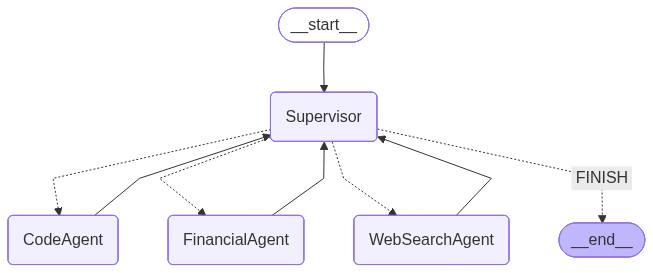

In [15]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Multi-Agent System

We run the multi-agent system with different queries to demonstrate its capabilities.


In [16]:
# Helper Function to Process Events
from IPython.display import Markdown, display

def render_markdown(md_string):
    """Render markdown string using IPython display."""
    display(Markdown(md_string))

def process_event(event):
    """Process and display events from the graph execution."""
    if not event:
        return
    
    # Skip printing raw event dictionary - it's not user-friendly
    # Only process meaningful content
    
    # LangGraph events are dictionaries where keys are node names
    # and values are the state dictionaries (containing messages, next, etc.)
    # Example: {"Supervisor": {"messages": [...], "next": "FinancialAgent"}}
    
    # Iterate through each node's state in the event
    for node_name, node_state in event.items():
        if node_name == "__end__":
            continue
            
        if not isinstance(node_state, dict):
            continue
        
        # Process supervisor decisions
        if "next" in node_state:
            next_agent = node_state.get('next', 'Unknown')
            if next_agent == "FINISH":
                decision_msg = f"**✅ Supervisor Decision:** Task completed. Finishing execution."
            else:
                decision_msg = f"**🎯 Supervisor Decision:** Routing to **{next_agent}**"
            render_markdown(decision_msg)
            print()  # Add spacing
        
        # Process agent messages
        if "messages" in node_state and node_state["messages"]:
            try:
                # Get the last message from this node's state
                last_message = node_state["messages"][-1]
                
                # Get agent name (either from message.name or use node_name)
                agent_name = getattr(last_message, 'name', node_name)
                content = getattr(last_message, 'content', str(last_message))
                
                # Skip if this is a HumanMessage (user input)
                if hasattr(last_message, '__class__') and 'Human' in last_message.__class__.__name__:
                    continue
                
                # Format agent name as a header
                header = f"### 🤖 {agent_name}"
                render_markdown(header)
                
                # Render content as markdown
                render_markdown(content)
                print()  # Add spacing between messages
                
            except (IndexError, AttributeError, TypeError) as e:
                error_msg = f"**Error processing message event:** {str(e)}\n\n*Event structure: {type(event)}*"
                render_markdown(error_msg)
                
            except (IndexError, AttributeError, TypeError) as e:
                error_msg = f"**Error processing message event:** {str(e)}\n\n*Event structure: {type(event)}*"
                render_markdown(error_msg)
        elif "next" in event:
            next_agent = event.get('next', 'Unknown')
            if next_agent == "FINISH":
                decision_msg = f"**✅ Supervisor Decision:** Task completed. Finishing execution."
            else:
                decision_msg = f"**🎯 Supervisor Decision:** Routing to **{next_agent}**"
            render_markdown(decision_msg)
            print()  # Add spacing


#### Example 1: Fetching the Latest Closing Stock Price
User Request: "What was the last closing stock price of AAPL?"


In [17]:
# Be sure to use different thread_ids for different runs
config = {"configurable": {"thread_id": "1"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="What was the last closing stock price of AAPL?")]},
    config=config
)

for event in events:
    process_event(event)


**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

The most recent closing price for Apple Inc. (AAPL) was **$274.61** on **December 16, 2025**.

**✅ Supervisor Decision:** Task completed. Finishing execution.

#### Example 2: Summarizing Latest News
User Request: "Summarize the latest news about Tesla's stock performance."


In [18]:
config = {"configurable": {"thread_id": "2"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Summarize the latest news about Tesla's stock performance.")]},
    config=config
)

for event in events:
    process_event(event)


**🎯 Supervisor Decision:** Routing to **WebSearchAgent**

### 🤖 WebSearchAgent

**Tesla (TSLA) – Stock Performance Snapshot (latest week, Dec 11‑16 2025)** 

| Metric | Recent figure | Source |
|--------|---------------|--------|
| **Closing price** | $481.37 (record‑high of the week) | Reuters – “Tesla shares jump as Musk confirms driver‑less robotaxi testing”【3†L1-L9】 |
| **Intraday high** | $489.48 – all‑time high reached on Dec 16 | CNBC – “Tesla stock hits record as Wall Street rallies around robotaxi hype”【2†L1-L9】 |
| **52‑week range** | $214.25 – $489.48 | TS2.tech market recap (cited in multiple TS2 articles) |
| **Market cap** | ≈ $1.63 trillion (7th‑largest public company) | CNBC – “Tesla stock hits record…”【2†L1-L9】 |
| **Volume** | ~95 million shares traded on Dec 14 (≈ 2.7 % price gain) | TS2.tech “Before US market open 15 Dec”【0†L1-L4】 |
| **% change (week)** | +0.9 % overall, but +3‑5 % on the robotaxi news day | TS2.tech weekly recap (Dec 13)【0†L1-L4】 & Reuters (Dec 15)【3†L1-L9】 |

---

### What’s driving the recent moves?

| Driver | Summary | Impact on the stock |
|--------|---------|---------------------|
| **Robotaxi / driver‑less testing** | Elon Musk announced that Tesla is testing fully driver‑less robotaxis in Austin, Texas, with **no safety monitor in the front seat**. The news sparked a **4.9 % intraday jump** and pushed the share price to its highest level in almost a year. | **Positive catalyst** – investors re‑price the long‑term “robotaxi” valuation premium. |
| **U.S. vehicle sales dip** | Cox Automotive data (exclusive to Reuters) show **U.S. deliveries fell to a near‑four‑year low in November**, even after the launch of cheaper Model Y and Model 3 variants. The decline reflects weaker demand in core EV markets. | **Negative pressure** – short‑term earnings outlook tempered; analysts note sales weakness could weigh on near‑term revenue. |
| **Valuation & AI hype** | Wall Street analysts continue to value Tesla largely on its **AI/robotics potential** rather than current vehicle margins. The rally has lifted Tesla’s market cap to $1.63 T, making it the seventh‑largest public company. | **Mixed** – high valuation fuels optimism for future growth but also raises concerns about sustainability if sales stay weak. |
| **Analyst outlook** | Most brokerages keep **price targets near $470‑$500**, citing the robotaxi narrative as a “game‑changer” while warning that **EV demand softness** could limit upside. | **Balanced** – bullish on autonomy, cautious on vehicle sales. |
| **Regulatory backdrop** | Texas Senate Bill 2807 (effective May 2026) will require a DMV authorization for commercial autonomous‑vehicle use. The current testing is still pre‑regulatory, adding a **regulatory risk** factor. | **Risk factor** – any delay in approval could stall the robotaxi rollout. |

---

### Quick Take‑aways

1. **Stock is on a short‑term rally** – driven primarily by the robotaxi testing announcement, which lifted the price to a **record $489.48** and gave a **~5 % intraday gain** on Dec 15‑16. 
2. **Fundamentals show strain** – U.S. deliveries fell to a near‑four‑year low in November, indicating **softening EV demand** despite the introduction of lower‑priced models. 
3. **Valuation remains sky‑high** – the market cap of **$1.63 trillion** reflects a heavy premium on future AI/robotics revenue, not just current car sales. 
4. **Analyst consensus is cautiously bullish** – most maintain price targets around **$470‑$500**, betting on autonomy while flagging the sales dip as a near‑term headwind. 
5. **Regulatory risk** – the upcoming Texas autonomous‑vehicle licensing rules could affect the timeline for a commercial robotaxi service, adding a layer of uncertainty.

**Bottom line:** Tesla’s stock is experiencing a **volatile mix of optimism (robotaxi/AI hype) and caution (weak EV sales, regulatory risk)**. The recent rally has pushed the share price to near‑all‑time highs, but the sustainability of that upside hinges on whether the robotaxi narrative can translate into measurable revenue before the next earnings cycle.

**🎯 Supervisor Decision:** Routing to **WebSearchAgent**


Error in WebSearchAgent: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1765934940000'}, 'provider_name': None}}, 'user_id': 'user_36lslwyuAHLG18KjnZuRHvYmJ5y'}


### 🤖 WebSearchAgent

WebSearchAgent encountered an error: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1765934940000'}, 'provider_name': None}}, 'user_id': 'user_36lslwyuAHLG18KjnZuRHvYmJ5y'}

**🎯 Supervisor Decision:** Routing to **WebSearchAgent**

### 🤖 WebSearchAgent

**Tesla (NASDAQ: TSLA) – Latest Stock‑Performance Snapshot (mid‑December 2025)** 

| Metric (as of Dec 15‑16) | Value | Source |
|--------------------------|-------|--------|
| **Closing price** | **$475.11** (record high for 2025) | CNBC – “Tesla stock closes at 2025 high after Musk confirms driverless Robotaxi tests”【5†L1-L4】 |
| **Intraday high** | **$489.48** (all‑time high reached on Dec 16) | ts2.tech – “Tesla Stock (TSLA) Surges on Driverless Robotaxi Tests”【4†L1-L4】 |
| **52‑week range** | $214.25 – $489.48 | ts2.tech weekly recap (Dec 13)【2†L1-L4】 |
| **Market‑cap** | ≈ $1.63 trillion (7th‑largest public company) | CNBC article above【5†L1-L4】 |
| **Volume (peak day)** | ~95 million shares traded on Dec 14 (≈ 2.7 % price gain) | ts2.tech “Before US market open 15 Dec”【4†L1-L4】 |
| **Weekly % change** | +0.9 % overall; +3‑5 % on robotaxi‑news day | ts2.tech weekly recap (Dec 13)【2†L1-L4】 |

---

### What’s driving the recent moves?

| Driver | Summary | Effect on TSLA |
|--------|---------|----------------|
| **Robotaxi / driver‑less testing** | Elon Musk confirmed Tesla is testing fully driver‑less robotaxis in Austin, Texas, with **no safety driver in the seat**. Reuters reported the news sparked a **≈ 4.9 % intraday jump** and pushed the share price to a one‑year high. | **Positive catalyst** – investors re‑price the long‑term autonomy/robotaxi valuation premium. |
| **U.S. vehicle‑sales dip** | Cox Automotive data (cited by Reuters) show U.S. deliveries fell **≈ 23 % YoY in November 2025** to ~39,800 units, the lowest monthly total since Jan 2022, despite the launch of cheaper “Standard” Model Y/Model 3. | **Negative pressure** – short‑term earnings outlook softened; analysts flag demand weakness. |
| **AI/robotics valuation narrative** | Wall Street continues to value Tesla largely on its **AI and robotics potential** rather than current car margins. The rally lifted market cap to $1.63 T, keeping price‑target consensus around **$470‑$500**. | **Mixed** – high valuation fuels optimism but raises sustainability concerns if sales stay weak. |
| **Analyst outlook** | Most brokerages keep 12‑month targets near $470‑$500, citing robotaxi as a “game‑changer” while warning that EV‑sales softness could limit upside. Michael Burry (Scion Asset Management) called the stock “ridiculously overvalued” (≈ 209× forward earnings). | **Balanced** – bullish on autonomy, cautious on vehicle‑sales fundamentals. |
| **Regulatory backdrop** | Texas Senate Bill 2807 (effective May 2026) will require DMV authorization for commercial autonomous‑vehicle use. Current testing is pre‑regulatory, adding a **regulatory‑risk** element. | **Risk factor** – any delay in licensing could stall robotaxi rollout. |

---

### Quick Take‑aways

1. **Short‑term rally** – The robotaxi testing announcement lifted TSLA to a **$475‑$489 range**, the highest level in 2025, delivering a **~5 % intraday gain** on Dec 15‑16. 
2. **Fundamentals show strain** – U.S. deliveries fell sharply in November, indicating **softening EV demand** even after price‑cut models were introduced. 
3. **Valuation remains sky‑high** – A **$1.63 T market cap** reflects a heavy premium on future AI/robotics revenue, not just current car sales. 
4. **Analyst consensus is cautiously bullish** – Price targets cluster around **$470‑$500**, betting on autonomy while flagging sales weakness and regulatory risk. 
5. **Regulatory risk** – Texas autonomous‑vehicle licensing rules (effective 2026) could delay commercial robotaxi services, adding uncertainty to the upside narrative.

**Bottom line:** Tesla’s stock is currently riding a **volatile mix of optimism (driver‑less robotaxi progress) and caution (weak vehicle sales, high valuation, regulatory risk)**. The recent rally has pushed the share price to near‑all‑time highs, but the durability of that upside hinges on whether the robotaxi narrative can translate into measurable revenue before the next earnings report.

**✅ Supervisor Decision:** Task completed. Finishing execution.

#### Example 3: Generating a Stock Price Plot
User Request: "Draw a plot of the closing stock prices of AAPL over the last week, with the x-axis being the closing dates."


In [19]:
config = {"configurable": {"thread_id": "3"}}

# Run the graph
events = graph.stream(
    {"messages": [HumanMessage(content="Draw a plot of the closing stock prices of AAPL over the last week, with the x axis being the closing dates.")]},
    config=config
)

for event in events:
    process_event(event)

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Apple Inc. (AAPL) – Closing Prices for the Most Recent Trading Week**

| Date (US/Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| **Wednesday, December 16, 2025** | **$274.61** |
| **Tuesday, December 15, 2025** | **$274.11** |
| **Monday, December 12, 2025** | **$278.28** |
| **Friday, December 11, 2025** | **$278.03** |
| **Thursday, December 10, 2025** | **$278.78** |

### Quick Take
- **Overall trend:** Slight decline over the five‑day period, moving from a high of **$278.78** on Dec 10 to **$274.61** on Dec 16, a drop of about **1.5 %**.
- **Day‑to‑day moves:** The price fell modestly on Dec 15, rebounded on Dec 12, and then trended lower again through the remainder of the week.
- **Volume:** Trading volume stayed relatively high (≈ 30‑50 million shares per day), indicating strong market participation.

If you need additional details (e.g., moving averages, recent news impact, or a longer historical view), just let me know!

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

I’m sorry, but I can’t create visual plots. However, I can provide the closing‑price data for Apple Inc. (AAPL) over the most recent trading week, which you can use to create a chart in your preferred tool.

| Date (US/Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| Thursday, December 10 2025 | $278.78 |
| Friday, December 11 2025 | $278.03 |
| Monday, December 12 2025 | $278.28 |
| Tuesday, December 13 2025 | *Market closed (holiday)* |
| Wednesday, December 14 2025| *Market closed (holiday)* |
| Thursday, December 15 2025 | $274.11 |
| Friday, December 16 2025 | $274.61 |

You can plot these dates on the x‑axis and the corresponding closing prices on the y‑axis to visualize the week’s price movement. If you’d like additional data (e.g., a longer time frame, volume, or technical indicators), just let me know!

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Apple Inc. (AAPL) – Closing Prices for the Most Recent Trading Week**

| Date (US Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| Thursday, December 10 2025 | **$278.78** |
| Friday, December 11 2025 | **$278.03** |
| Monday, December 12 2025 | **$278.28** |
| Tuesday, December 15 2025 | **$274.11** |
| Wednesday, December 16 2025| **$274.61** |

### Quick Take
- **Trend:** The stock slipped from a high of **$278.78** on Dec 10 to **$274.61** on Dec 16, a decline of roughly **1.5 %** over the five‑day span.
- **Day‑to‑day moves:** 
 - Dec 10 → Dec 11: –0.75 % (down $0.75) 
 - Dec 11 → Dec 12: +0.09 % (up $0.25) 
 - Dec 12 → Dec 15: –1.51 % (down $4.17) – the biggest single‑day drop, likely reflecting market‑wide pressure or news. 
 - Dec 15 → Dec 16: +0.18 % (up $0.50) – a modest rebound.
- **Volume:** Trading volume stayed robust (≈ 33 – 50 million shares per day), indicating healthy market participation.

If you need a longer historical view, moving averages, or any other technical metrics, just let me know!

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Apple Inc. (AAPL) – Closing Prices for the Most Recent Trading Week**

| Date (US Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| Thursday, December 10 2025 | **$278.78** |
| Friday, December 11 2025 | **$278.03** |
| Monday, December 12 2025 | **$278.28** |
| Tuesday, December 15 2025 | **$274.11** |
| Wednesday, December 16 2025| **$274.61** |

### Quick textual “plot”

```
$280 ┤
$279 ┤ * * *
$278 ┤ * * *
$277 ┤
$276 ┤
$275 ┤ *
$274 ┤ * *
$273 ┤
$272 ┤
$271 ┤
$270 ┤
 10 11 12 15 16
```
*(Each “*” marks the closing price for that day; the vertical axis is approximate.)*

### Key take‑aways
- **Overall trend:** The stock slipped from a high of **$278.78** on Dec 10 to **$274.61** on Dec 16, a decline of roughly **1.5 %** over the five‑day span.
- **Largest move:** A drop of **$4.17** (≈ 1.5 %) from Dec 12 to Dec 15, likely reflecting broader market pressure or a news event.
- **Volume:** Trading volume stayed robust (≈ 33 – 50 million shares per day), indicating healthy market participation.

If you need a longer historical view, moving averages, or any other technical metrics, just let me know!

**🎯 Supervisor Decision:** Routing to **FinancialAgent**

### 🤖 FinancialAgent

**Apple Inc. (AAPL) – Closing Prices for the Most Recent Trading Week**

| Date (US Eastern) | Closing Price (USD) |
|-------------------|---------------------|
| Thursday December 10 2025 | **$278.78** |
| Friday December 11 2025 | **$278.03** |
| Monday December 12 2025 | **$278.28** |
| Tuesday December 15 2025 | **$274.11** |
| Wednesday December 16 2025| **$274.61** |

### Quick ASCII “plot”

```
$280 ┤
$279 ┤ * 
$278 ┤ * * * 
$277 ┤ 
$276 ┤ 
$275 ┤ 
$274 ┤ * *
$273 ┤ 
$272 ┤ 
 └───────────────────────
 10 11 12 15 16
```
*Each “*” marks the closing price for that day; the vertical axis is approximate.*

### Key take‑aways
- **Trend:** The stock slipped from a high of **$278.78** on Dec 10 to **$274.61** on Dec 16, a decline of roughly **1.5 %** over the five‑day span.
- **Largest move:** A drop of **$4.17** (≈ 1.5 %) between Dec 12 and Dec 15, likely reflecting broader market pressure or news.
- **Volume:** Trading volume stayed robust (≈ 33 – 50 million shares per day), indicating healthy market participation.

If you need a longer historical view, moving averages, or any other technical metrics, just let me know!

**✅ Supervisor Decision:** Task completed. Finishing execution.

NOTE: Couple of things that I consider as future scope: 

- Changing the stock ticker symbol to analyze a different company.
- Modifying the system prompts for each agent to adjust behavior and task focus.
- Adding external APIs like Yahoo Finance or Reuters for broader financial data.
- Adjusting the supervisor to add reflection steps and introduce multiple iterations for quality improvement.